## MIDS267 - Week 6 - Lesson Notebook Two: Simple Diffusion Model


In this notebook we will use a simple [Diffusion Model](https://arxiv.org/pdf/2103.00020.pdf) to demonstrate how the noising/denoising process can result in novel outputs.  This notebook leverages the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/en/index) classes and is based on their [Diffusers notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=TUDXg6FERHmB).



This notebook illustrates a simple diffusion model where we start and the noising and de-noising process.  The diffusion model consists of two compnents -- a model (pretrained for us) and a scheduler.


Note: this model is intended for demonstration and research purposes. It is not intended for commercial use. There are other models that are released in the public domain that provide the functionality without the licensing constraints.  You can also find these on [Hugging Face](https://huggingface.co/models?other=clip&sort=trending).

This notebook runs on a T4 GPU in free Colab or Colab Pro.

## Setup

Install the diffuser classes in the Colab environment.

In [1]:
%%capture

!pip install -q diffusers
!pip install -q accelerate

These diffusion models operate on a simple principle of taking an image, applying random noise to the pixels, and then gradually removing the noise in a step by step fashion.  The result is a novel image.

We'll use [a pretrained model](https://huggingface.co/google/ddpm-church-256) in the Hugging Face library to run our experiments. The diffusion model is trained to identify the "noise residual", that is the difference between an input image and a less noisy image.  This loop is repeated a specified number of times (steps).


In [2]:
%%capture

from diffusers import UNet2DModel

checkpoint = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(checkpoint)

Let's look inside the model to see the architecture.

In [3]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

The model config shows us the default hyperparameters.

In [4]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2D'),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
   

`sample_size`: defines the size of the input image in terms of width x height

`in_channels`: sets the number of channels in the input image

`down_block_types` and `up_block_types`: the blocks inside the UNet architecture -- 2D convolutions in this case.


Our images are 256 x 256. We need to first get a random gaussian sample that is the same size as the image we intend to generate.

In [5]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

The trained model predicts either the slightly less noisy image, the difference between the slightly less noisy image and the input image or even something else. It is important to carefully read through the [model card](https://huggingface.co/google/ddpm-church-256) to know what the model has been trained on. In this case, the model predicts the noise residual (difference between the slightly less noisy image and the input image).

In [6]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

Notice the shape of the noisy residual matches the shape of the input as it will be used to subtract noise from the noisy image.

In [7]:
noisy_residual.shape

torch.Size([1, 3, 256, 256])

The job of the scheduler is to define a noise schedule which allows the model to learn to add noise during training and to compute the noisy_residual.  Schedulers essentially contain the algorithm used to compute the less noisy sample during inference e.g. they remove the noisy_residual from the model to create the less noisy sample.  They do not contain any trainable parameters.

The Hugging Face Diffusers library means you can swap out [different schedulers](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) to see what will work best.  For the purposes of this notebook and demonstration we'll first use the DDIM scheduler  which is very fast but sacrifices some image quality.  At the end we provide a cell with the DDPM scheduler which is an order of magnitude slower but provides much better image quality.



In [8]:
%%capture

from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_config(checkpoint)

In [9]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('clip_sample', True),
            ('set_alpha_to_one', True),
            ('steps_offset', 0),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['thresholding',
              'steps_offset',
              'dynamic_thresholding_ratio',
              'clip_sample_range',
              'prediction_type',
              'rescale_betas_zero_snr',
              'timestep_spacing',
              'set_alpha_to_one',
              'sample_max_value']),
            ('_class_name', 'DDIMScheduler'),
  

Schedulers define...

* `num_train_timesteps` defines the number of timesteps to complete the denoising process, e.g. how many timesteps are need to process random gaussian noise to a data sample.
* `beta_schedule` defines the type of noise schedule that will be used for inference and training
* `beta_start` and `beta_end` define the smallest noise value and highest noise value of the schedule.

The scheduler includes a step() method that takes as input the current noisy sample, the number of the time_step, and the noisy_residual and uses that to compute the less noisy image.

By looping over this step() call the prescribed number of times e.g. decrement step number to get to zero, the model goes from a seemingly random pattern to an image reminiscent of the images on which the model was trained -- in this case images of churches.

In [10]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

Set the number of steps it will take to denoise the image.

In [11]:
scheduler.set_timesteps(num_inference_steps=100)

Here is a utility function to display the "image" every n steps so we can see the final image emerging from the noise.

In [12]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

Now we can create our denoising loop:
1. Predict the residual of the less noisy sample with the model.
2. Compute the less noisy sample with the scheduler.

Let's generate an image and see the state of the generated image every 10 steps.  It looks like random noise at the begining and then the image emerges toward the end of the steps.  Earlier we set this to go 100 steps.

  9%|▉         | 9/100 [00:01<00:11,  7.82it/s]

'Image at step 10'

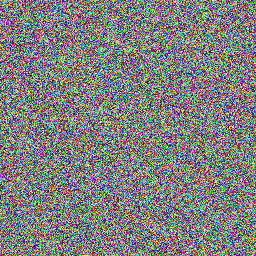

 19%|█▉        | 19/100 [00:02<00:09,  8.80it/s]

'Image at step 20'

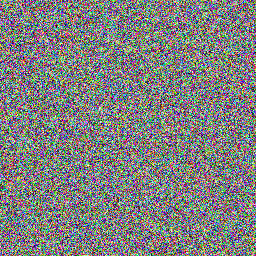

 29%|██▉       | 29/100 [00:03<00:08,  8.82it/s]

'Image at step 30'

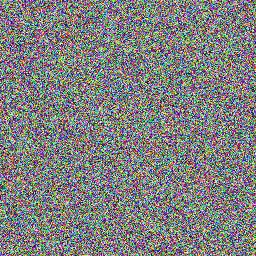

 39%|███▉      | 39/100 [00:05<00:06,  8.85it/s]

'Image at step 40'

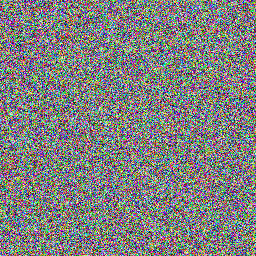

 49%|████▉     | 49/100 [00:06<00:05,  8.77it/s]

'Image at step 50'

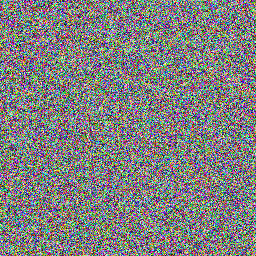

 59%|█████▉    | 59/100 [00:07<00:04,  8.74it/s]

'Image at step 60'

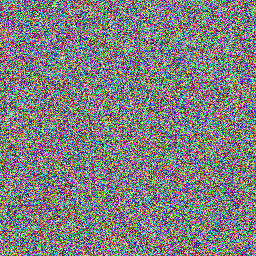

 69%|██████▉   | 69/100 [00:08<00:03,  8.69it/s]

'Image at step 70'

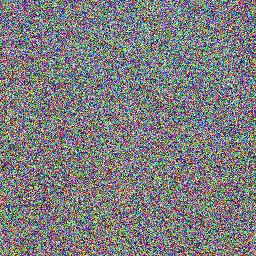

 79%|███████▉  | 79/100 [00:09<00:02,  8.75it/s]

'Image at step 80'

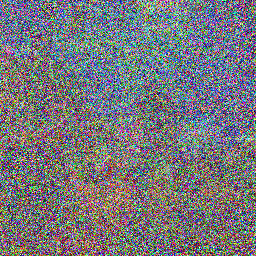

 89%|████████▉ | 89/100 [00:10<00:01,  8.76it/s]

'Image at step 90'

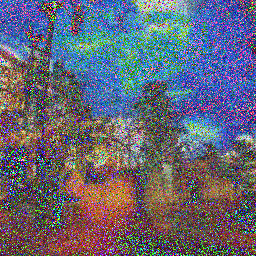

 99%|█████████▉| 99/100 [00:12<00:00,  8.38it/s]

'Image at step 100'

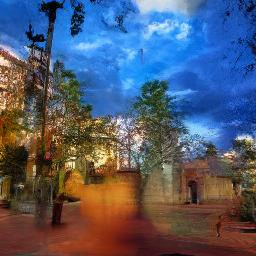

100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


In [13]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual (difference between less noisy image and input image)
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

Okay,  that's great.  The final image could be better.  Let's try a different scheduler.  Let's try the [DDPM scheduler](https://huggingface.co/docs/diffusers/en/api/schedulers/ddpm) which will take a lot longer but should produce a higher quality final image.

In [14]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler.from_config(checkpoint)

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


What are the default values of the scheduler? We'll leave them as is.

In [15]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['thresholding',
              'steps_offset',
              'dynamic_thresholding_ratio',
              'clip_sample_range',
              'prediction_type',
              'rescale_betas_zero_snr',
              'timestep_spacing',
              'sample_max_value']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_versi

Make sure we push everything to the GPU.

In [16]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

Now, let's run our denoising loop and watch the new image emerge.

  5%|▍         | 49/1000 [00:05<01:50,  8.59it/s]

'Image at step 50'

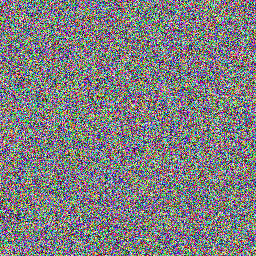

 10%|▉         | 99/1000 [00:11<01:44,  8.66it/s]

'Image at step 100'

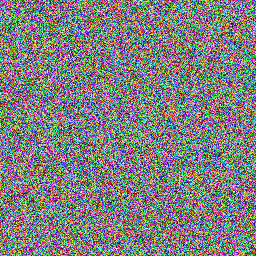

 15%|█▍        | 149/1000 [00:17<01:39,  8.53it/s]

'Image at step 150'

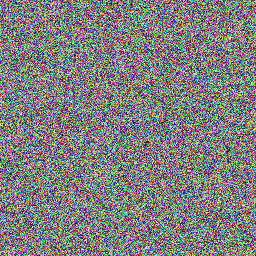

 20%|█▉        | 199/1000 [00:23<01:36,  8.33it/s]

'Image at step 200'

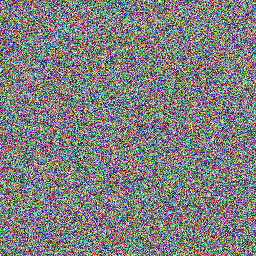

 25%|██▍       | 249/1000 [00:29<01:28,  8.53it/s]

'Image at step 250'

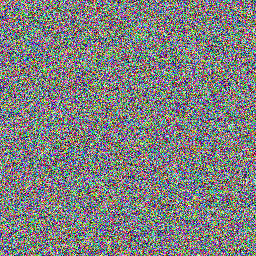

 30%|██▉       | 299/1000 [00:35<01:22,  8.46it/s]

'Image at step 300'

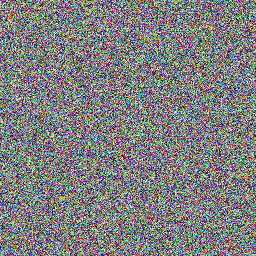

 35%|███▍      | 349/1000 [00:41<01:18,  8.26it/s]

'Image at step 350'

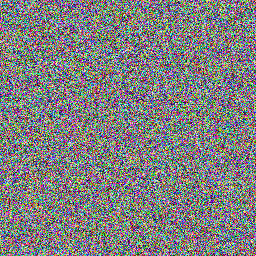

 40%|███▉      | 399/1000 [00:47<01:11,  8.36it/s]

'Image at step 400'

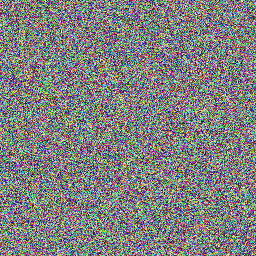

 45%|████▍     | 449/1000 [00:53<01:06,  8.33it/s]

'Image at step 450'

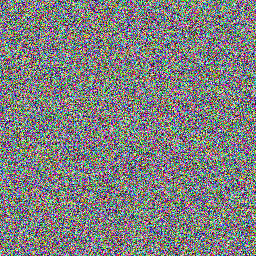

 50%|████▉     | 499/1000 [00:59<00:59,  8.36it/s]

'Image at step 500'

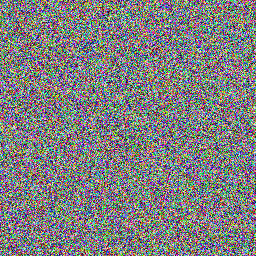

 55%|█████▍    | 549/1000 [01:05<00:54,  8.23it/s]

'Image at step 550'

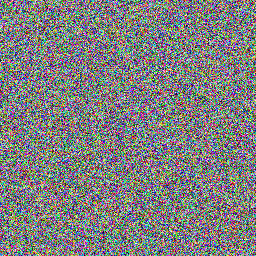

 60%|█████▉    | 599/1000 [01:11<00:50,  7.97it/s]

'Image at step 600'

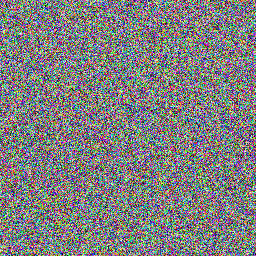

 65%|██████▍   | 649/1000 [01:17<00:43,  8.02it/s]

'Image at step 650'

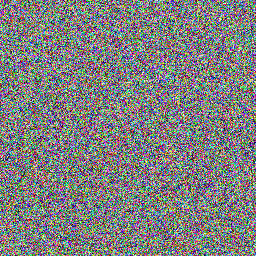

 70%|██████▉   | 699/1000 [01:24<00:38,  7.75it/s]

'Image at step 700'

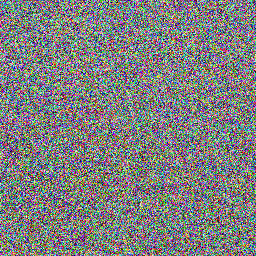

 75%|███████▍  | 749/1000 [01:30<00:31,  7.97it/s]

'Image at step 750'

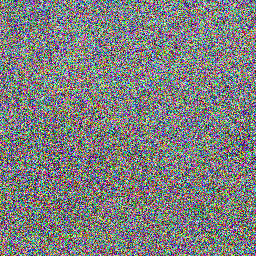

 80%|███████▉  | 799/1000 [01:36<00:24,  8.07it/s]

'Image at step 800'

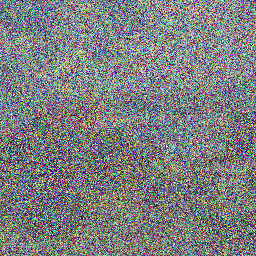

 85%|████████▍ | 849/1000 [01:42<00:18,  8.15it/s]

'Image at step 850'

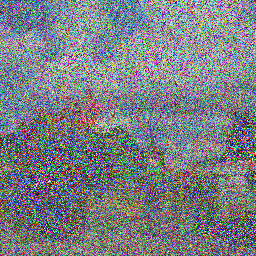

 90%|████████▉ | 899/1000 [01:49<00:12,  8.04it/s]

'Image at step 900'

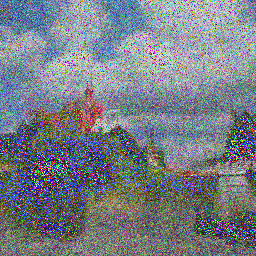

 95%|█████████▍| 949/1000 [01:55<00:06,  8.16it/s]

'Image at step 950'

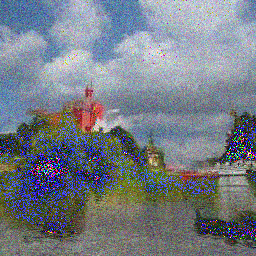

100%|█████████▉| 999/1000 [02:01<00:00,  8.13it/s]

'Image at step 1000'

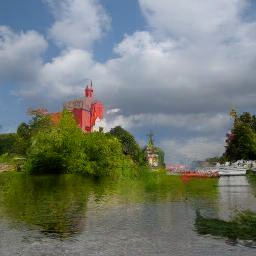

100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]


In [17]:
#denoising loop
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)